 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#Visualize-the-task-of-the-network" data-toc-modified-id="Visualize-the-task-of-the-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualize the task of the network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#Some-tests-with-Keras" data-toc-modified-id="Some-tests-with-Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some tests with Keras</a></span><ul class="toc-item"><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#Fully-connected-neural-network" data-toc-modified-id="Fully-connected-neural-network-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fully connected neural network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#Convolutional-neural-network" data-toc-modified-id="Convolutional-neural-network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Convolutional neural network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#A-better-network?" data-toc-modified-id="A-better-network?-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>A better network?</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#With-batch-normalization" data-toc-modified-id="With-batch-normalization-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>With batch normalization</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#A-much-more-complex-model!" data-toc-modified-id="A-much-more-complex-model!-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>A much more complex model!</a></span></li></ul></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_cbrain.ipynb#Visualize-predictions" data-toc-modified-id="Visualize-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize predictions</a></span></li></ul></div>

# A Keras implementation of CBRAIN

In this notebook I am going to write my own implementation of CBRAIN, mostly in Keras. Primarily I am doing this, so that I actually understand what is going on.

This notebook uses functions and classes which are defined in the following helper scripts:
- `utils.py`: General utility functions including visualization
- `data_generator.py`: Definition of DataGenerator and DataSet class. The former is not used at the moment.
- `models.py`: Definition of the Keras neural nets
- `losses.py`: Definition of the custom loss functions
- `run_experiments.py`: Wrapper script to run experiments outside of notebook

**TODO**
- Sample split
- Write good visualization script for individual examples
    - Add mean and std to DataSet --> Use to also show non-normalized features
    - Also non-rescaled targets
    - Maybe with new DataSet function we can get more lat info
- Write scripts for summary plots
- Write convenient run_experiment script
- DataLoading function for RNNs and CNNs

In [7]:
# Imports
from importlib import reload
import utils; reload(utils);
from utils import *
import data_generator; reload(data_generator);
from data_generator import *
import models; reload(models);
from models import *
%matplotlib inline

In [2]:
# Limit Tensorflow GPU memory usage. 
# Note that apparently it's not possible to change the allocation or release memory again.
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8   # GPU RAM usage fraction of 4GB
sess = tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

In [3]:
# Define data paths
# sample_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/sample/'   # 100,000 samples
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/detailed_files/' # Full dataset

In [4]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'OMEGA': 2,           # [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'QRL': 2,             # Long wave heating rate [z, sample]
    'QRS': 2,             # Short wave heating rate [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'LAT': 1,             # Latitude [sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
})

## Visualize the task of the network

Let's start by getting an intuition of the task at hand. For this let's just plot some inputs (features) and outputs (targets) of the algorithm.

In [60]:
# Open the training set
train_out = nc.Dataset(data_dir + 'SPCAM_outputs_train.nc')

Let's get a feeling for the variability of the output

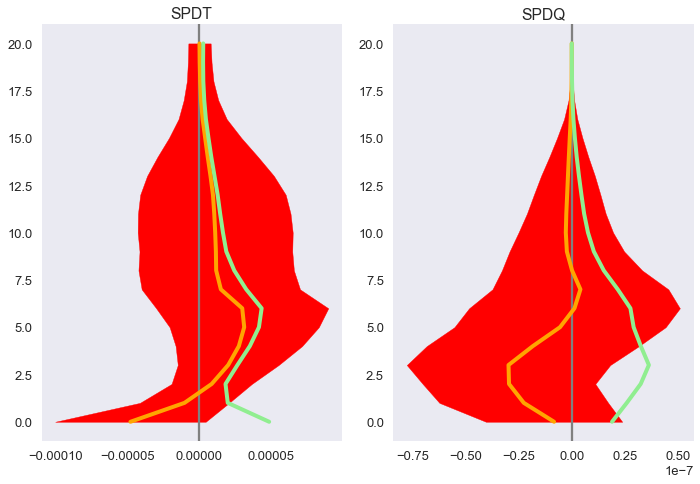

In [61]:
z = np.arange(train_out.variables['SPDT'][:].shape[0]-1, -1, -1)
fig, axes = plt.subplots(1, 2)
for i, var in enumerate([train_out.variables['SPDT'], train_out.variables['SPDQ']]):
    mean = np.mean(var[:], axis=1)
    mean_abs = np.mean(np.abs(var[:]), axis=1)
    mn = np.min(var[:], axis=1); mx = np.max(var[:], axis=1)
    std = np.std(var[:], axis=1, ddof=1)
    axes[i].set_title(var.name)
    axes[i].plot(mean, z, c='orange', lw=4)
    axes[i].plot(mean_abs, z, c='lightgreen', lw=4)
    #axes[i].fill_betweenx(z, mn, mx, zorder=0.1)
    axes[i].fill_betweenx(z, mean - std, mean + std, mx, zorder=0.15, color='r')
    axes[i].axvline(0, c='gray', zorder=0.2)
plt.tight_layout()
plt.show()

Note that the min-max range is much much larger. Next let's check out the dependency on latitude

In [62]:
lats = train_out.variables['LAT'][:]
spdt = train_out.variables['SPDT'][:]

In [63]:
lats.shape, spdt.shape

((3696230,), (21, 3696230))

In [64]:
b = binned_statistic(lats, spdt, bins=20, range=(lats.min(), lats.max()))

In [65]:
mean_lats = (b[1][1:] + b[1][:-1]) / 2.
mean_lats = ['%.0f' % l for l in mean_lats]

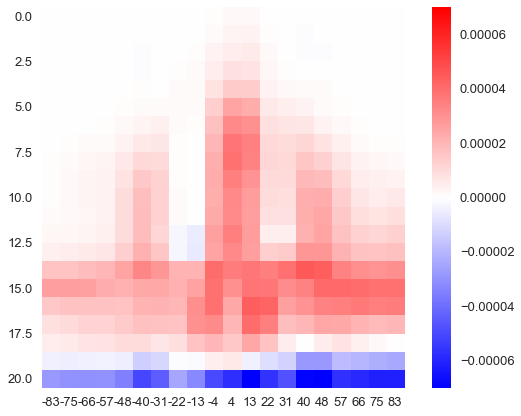

In [66]:
plt.imshow(b[0], cmap='bwr', vmin=-7e-5, vmax=7e-5)
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()

The ITCZ and the storm tracks are nicely visible. Let's also look at the variability

In [67]:
b = binned_statistic(lats, spdt, bins=20, statistic='std', range=(lats.min(), lats.max()))

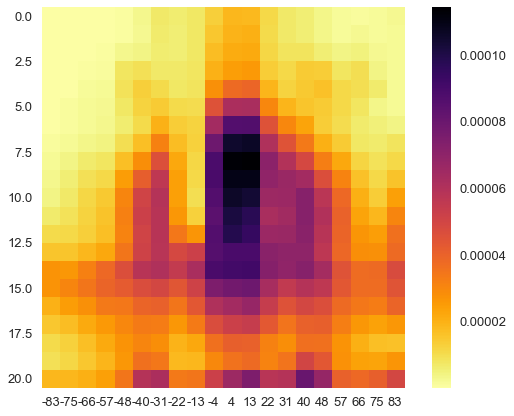

In [70]:
plt.imshow(b[0], cmap='inferno_r')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()

Correlates pretty well wit the means. By far the largest variability seems to be in the tropics.

Next, let's actually look at the features and targets for a few examples.

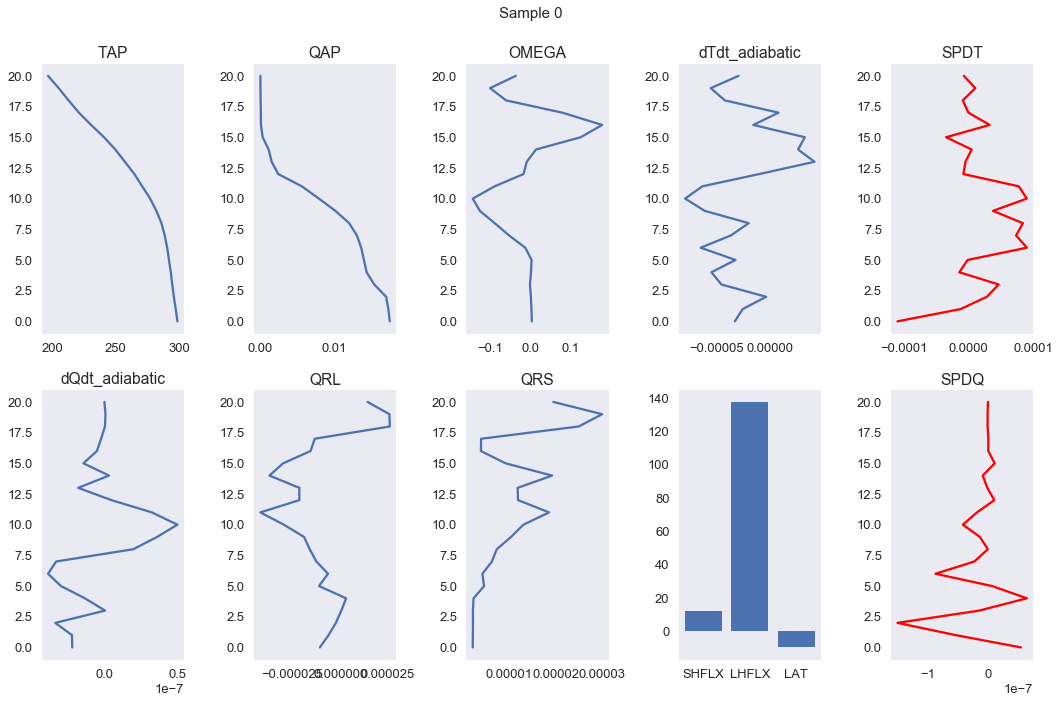

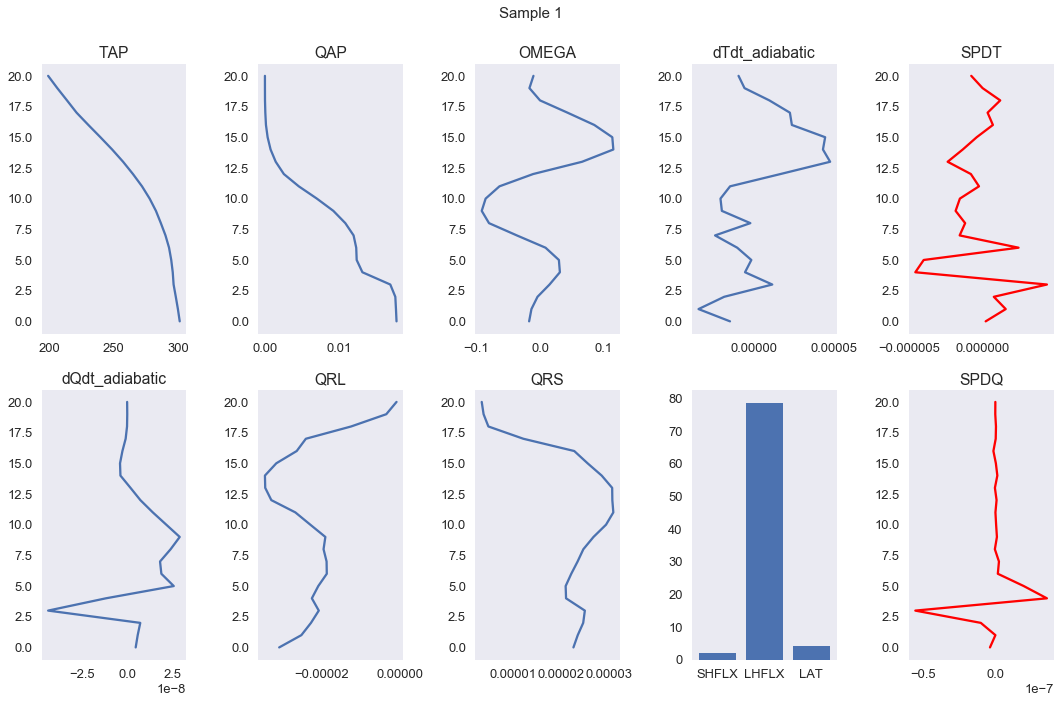

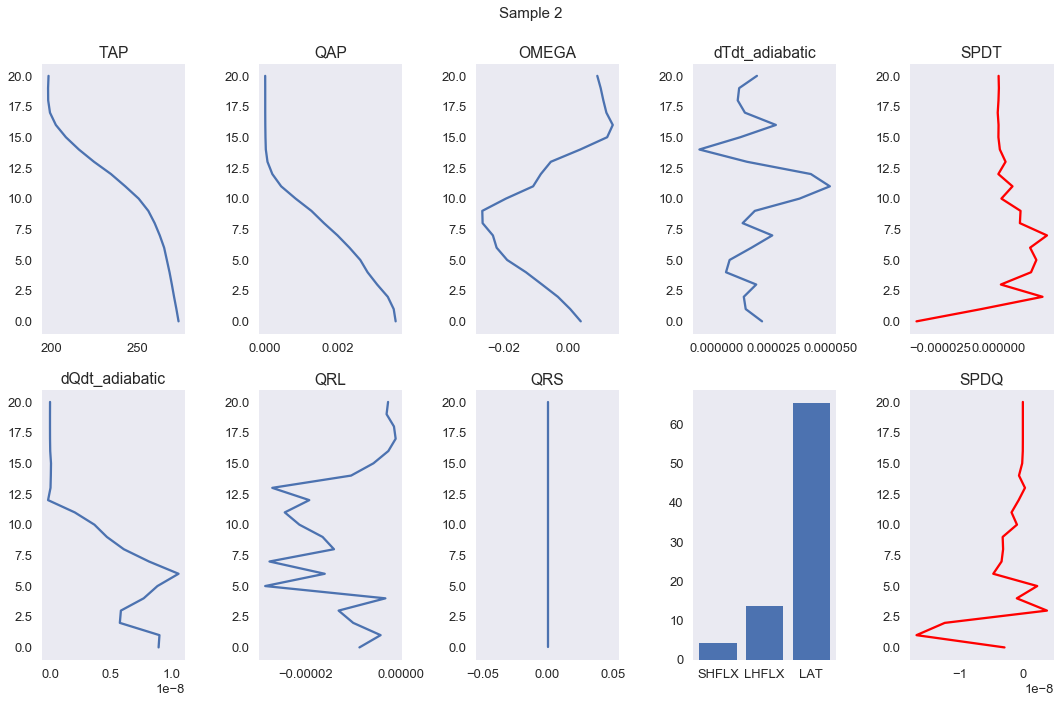

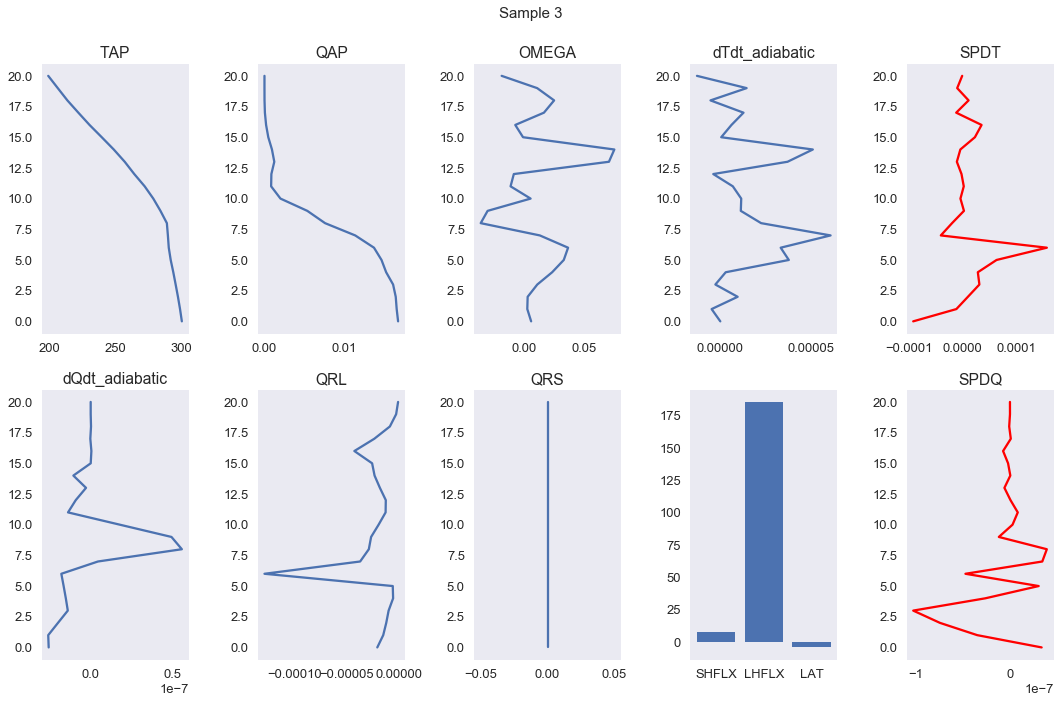

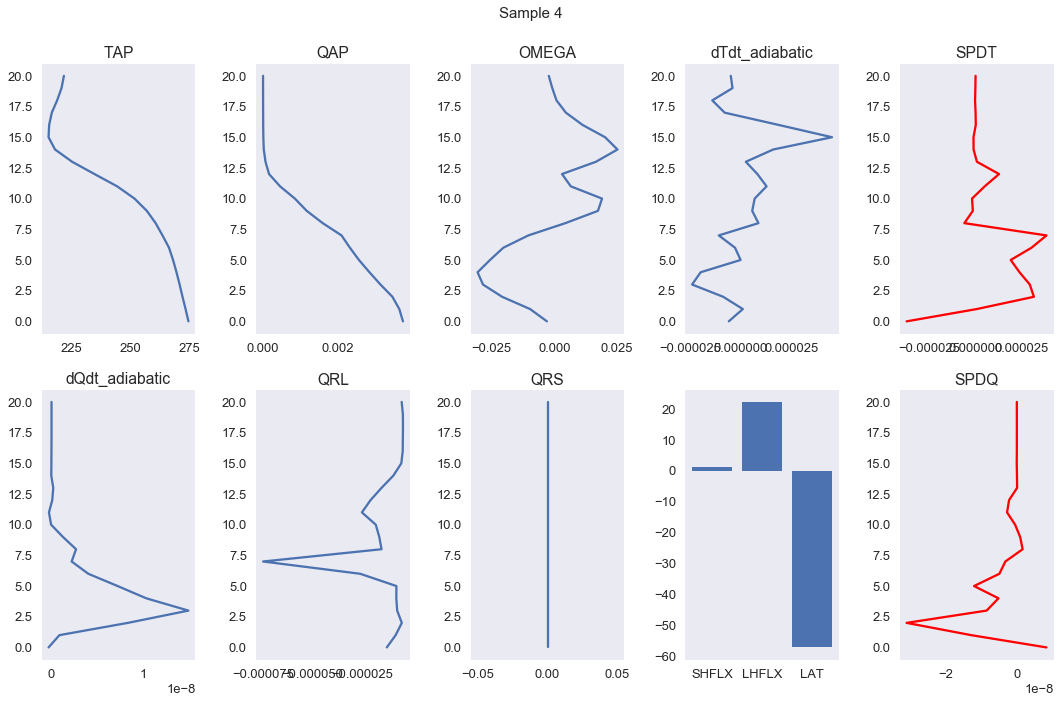

In [78]:
for i in range(5):
    vis_features_targets(train_out, i, feature_vars, target_vars)

Some thoughts for better visualization:
- Use scaled features and targets

## Some tests with Keras

### Fully connected neural network
I wrote a DataGenerator class which loads and scales the features and targets. This loads the entire dataset into RAM, so for the full dataset it might be quite memory intensive!

In [8]:
train_set = DataSet(data_dir, 'SPCAM_outputs_detailed_train.nc', 'SPCAM_mean_detailed.nc',
                    'SPCAM_std_detailed.nc', feature_vars.keys())
valid_set = DataSet(data_dir, 'SPCAM_outputs_detailed_valid.nc', 'SPCAM_mean_detailed.nc',
                    'SPCAM_std_detailed.nc', feature_vars.keys())

This uses about 4GB of CPU RAM.

In [56]:
# Create model
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], 
                 [32, 32], 0.001, 'mae')

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 32)                4832      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 42)                1386      
Total params: 7,274
Trainable params: 7,274
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(train_set.features, train_set.targets, batch_size=4096, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets),
          callbacks=[TensorBoard(log_dir='../logs/keras_fc_reference/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 17s - loss: 0.0505 - rmse: 0.0761 - log_loss: -1.4367 - total_error: 724.0357 - unexplained_error: 10034.6793 - rsquared: -12.8371 - total_error_avgAx0: 629.3406 - rsquared_avgAx0: -14.9329 - val_loss: 0.0241 - val_rmse: 0.0433 - val_log_loss: -1.5081 - val_total_error: 722.4017 - val_unexplained_error: 649.3537 - val_rsquared: 0.1013 - val_total_error_avgAx0: 628.0189 - val_rsquared_avgAx0: -0.0339
Epoch 2/10
3696230/3696230 [==============================] - 16s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0397 - unexplained_error: 649.9913 - rsquared: 0.1024 - total_error_avgAx0: 629.3428 - rsquared_avgAx0: -0.0328 - val_loss: 0.0241 - val_rmse: 0.0433 - val_log_loss: -1.5076 - val_total_error: 722.4017 - val_unexplained_error: 648.4726 - val_rsquared: 0.1025 - val_total_error_avgAx0: 628.0189 - val_rsquared_avgAx0: -0.0325
Epoch 3/10
3696230/369

### Convolutional neural network

In [12]:
train_set = DataSet(data_dir, 'SPCAM_outputs_detailed_train.nc', 'SPCAM_mean_detailed.nc',
                    'SPCAM_std_detailed.nc', feature_vars.keys(), convolution=True)
valid_set = DataSet(data_dir, 'SPCAM_outputs_detailed_valid.nc', 'SPCAM_mean_detailed.nc',
                    'SPCAM_std_detailed.nc', feature_vars.keys(), convolution=True)

In [13]:
train_set.features[0].shape, train_set.features[1].shape

((3681792, 21, 7), (3681792, 3))

In [8]:
train_set.features[0].shape, train_set.features[1].shape

((3696230, 21, 7), (3696230, 3))

In [63]:
model = conv_model(train_set.features[0].shape[1:], train_set.features[1].shape[1],
                   train_set.targets.shape[1], [32, 32], [100], 1e-3, 'mae')

In [64]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_12 (Conv1D)               (None, 21, 32)        704         input_9[0][0]                    
____________________________________________________________________________________________________
conv1d_13 (Conv1D)               (None, 21, 32)        3104        conv1d_12[0][0]                  
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 672)           0           conv1d_13[0][0]                  
___________________________________________________________________________________________

In [65]:
model.fit(train_set.features, train_set.targets, batch_size=128, epochs=2, 
          validation_data=(valid_set.features, valid_set.targets),
          callbacks=[TensorBoard(log_dir='../logs/keras_conv_reference/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/2
3696230/3696230 [==============================] - 206s - loss: 0.0185 - rmse: 0.0340 - log_loss: -1.6114 - total_error: 22.6305 - unexplained_error: 11.9207 - rsquared: 0.4693 - total_error_avgAx0: 19.5235 - rsquared_avgAx0: 0.3822 - val_loss: 0.0179 - val_rmse: 0.0328 - val_log_loss: -1.6268 - val_total_error: 22.5966 - val_unexplained_error: 11.0023 - val_rsquared: 0.5087 - val_total_error_avgAx0: 19.4991 - val_rsquared_avgAx0: 0.4284
Epoch 2/2
3696230/3696230 [==============================] - 206s - loss: 0.0179 - rmse: 0.0327 - log_loss: -1.6290 - total_error: 22.6305 - unexplained_error: 11.0509 - rsquared: 0.5083 - total_error_avgAx0: 19.5230 - rsquared_avgAx0: 0.4277 - val_loss: 0.0178 - val_rmse: 0.0325 - val_log_loss: -1.6325 - val_total_error: 22.5966 - val_unexplained_error: 10.9270 - val_rsquared: 0.5126 - val_total_error_avgAx0: 19.4991 - val_rsquared_avgAx0: 0.4329


### A better network?

NOT UPDATED

In [30]:
model = conv_model(data_set.features[0].shape[1:], data_set.features[1].shape[1],
                   data_set.targets.shape[1], [32, 32, 32], [500, 500], 1e-3, 'mae')

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 21, 32)        704         input_3[0][0]                    
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 21, 32)        3104        conv1d_3[0][0]                   
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 21, 32)        3104        conv1d_4[0][0]                   
___________________________________________________________________________________________

In [32]:
model.fit(data_set.features, data_set.targets, batch_size=128, epochs=1, validation_split=0.2,
          callbacks=[TensorBoard(log_dir='../logs/keras_conv_2/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/1
3696230/3696230 [==============================] - 274s - loss: 0.0158 - rmse: 0.0287 - log_loss: -1.7070 - total_error: 22.7470 - unexplained_error: 9.3108 - rsquared: 0.5892 - total_error_avgAx0: 19.6549 - rsquared_avgAx0: 0.5227 - val_loss: 0.0154 - val_rmse: 0.0280 - val_log_loss: -1.7123 - val_total_error: 22.0889 - val_unexplained_error: 8.6319 - val_rsquared: 0.6794 - val_total_error_avgAx0: 17.1452 - val_rsquared_avgAx0: 0.5510


### With batch normalization

NOT UPDATED

In [35]:
model = conv_model(data_set.features[0].shape[1:], data_set.features[1].shape[1],
                   data_set.targets.shape[1], [32, 32, 32], [500, 500], 1e-3, 'mae',
                   batch_norm=True)

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_6 (Conv1D)                (None, 21, 32)        704         input_5[0][0]                    
____________________________________________________________________________________________________
conv1d_7 (Conv1D)                (None, 21, 32)        3104        conv1d_6[0][0]                   
____________________________________________________________________________________________________
conv1d_8 (Conv1D)                (None, 21, 32)        3104        conv1d_7[0][0]                   
___________________________________________________________________________________________

In [39]:
model.fit(data_set.features, data_set.targets, batch_size=128, epochs=1, validation_split=0.2,
          callbacks=[TensorBoard(log_dir='../logs/keras_conv_2_bn/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/1
 494080/3696230 [===>..........................] - ETA: 308s - loss: 0.0172 - rmse: 0.0304 - log_loss: -1.6750 - total_error: 22.6480 - unexplained_error: 10.6890 - rsquared: 0.5280 - total_error_avgAx0: 19.5635 - rsquared_avgAx0: 0.4515

KeyboardInterrupt: 

### A much more complex model!

Let's try to get the model to overfit!

In [6]:
model = conv_model(train_set.features[0].shape[1:], train_set.features[1].shape[1],
                   train_set.targets.shape[1], [36, 64, 128], [4000, 2000, 1000], 1e-3, 'mae',
                   batch_norm=False, kernel_size=5)

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 21, 36)        1296        input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 21, 64)        11584       conv1d_1[0][0]                   
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 21, 128)       41088       conv1d_2[0][0]                   
___________________________________________________________________________________________

In [9]:
model.fit(train_set.features, train_set.targets, batch_size=1024, epochs=1,
          validation_data=(valid_set.features, valid_set.targets),
          callbacks=[TensorBoard(log_dir='../logs/keras_conv_3/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/1
3696230/3696230 [==============================] - 833s - loss: 0.0158 - rmse: 0.0288 - log_loss: -1.7085 - total_error: 181.0432 - unexplained_error: 75.3998 - rsquared: 0.5834 - total_error_avgAx0: 157.2486 - rsquared_avgAx0: 0.5201 - val_loss: 0.0151 - val_rmse: 0.0275 - val_log_loss: -1.7296 - val_total_error: 180.7248 - val_unexplained_error: 67.9039 - val_rsquared: 0.6238 - val_total_error_avgAx0: 156.9976 - val_rsquared_avgAx0: 0.5667


In [11]:
model.optimizer.lr = 1e-4

In [12]:
model.fit(train_set.features, train_set.targets, batch_size=128, epochs=20,
          validation_data=(valid_set.features, valid_set.targets),
          callbacks=[TensorBoard(log_dir='../logs/keras_conv_3/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/20
3696230/3696230 [==============================] - 2312s - loss: 0.0153 - rmse: 0.0278 - log_loss: -1.7236 - total_error: 22.6305 - unexplained_error: 8.7579 - rsquared: 0.6111 - total_error_avgAx0: 19.5236 - rsquared_avgAx0: 0.5475 - val_loss: 0.0152 - val_rmse: 0.0277 - val_log_loss: -1.7258 - val_total_error: 22.5966 - val_unexplained_error: 8.7115 - val_rsquared: 0.6133 - val_total_error_avgAx0: 19.4991 - val_rsquared_avgAx0: 0.5502
Epoch 2/20
3696230/3696230 [==============================] - 2312s - loss: 0.0152 - rmse: 0.0276 - log_loss: -1.7284 - total_error: 22.6305 - unexplained_error: 8.6049 - rsquared: 0.6178 - total_error_avgAx0: 19.5231 - rsquared_avgAx0: 0.5552 - val_loss: 0.0152 - val_rmse: 0.0276 - val_log_loss: -1.7276 - val_total_error: 22.5966 - val_unexplained_error: 8.5827 - val_rsquared: 0.6174 - val_total_error_avgAx0: 19.4991 - val_rsquared_avgAx0: 0.5548
Epoch 3/20
3696230/3696230 [===============

In [14]:
import tensorflow as tf

In [15]:
model.optimizer.lr = tf.Variable(1e-4)

In [17]:
model.save('/home/s/S.Rasp/repositories/CBRAIN/models/complex_cnn2.h5')

## Visualize predictions

In [5]:
from keras.utils.generic_utils import get_custom_objects

In [6]:
metrics_dict = dict([(f.__name__, f) for f in metrics])

In [7]:
metrics_dict

{'log_loss': <function losses.log_loss>,
 'rmse': <function losses.rmse>,
 'rsquared': <function losses.rsquared>,
 'rsquared_avgAx0': <function losses.rsquared_avgAx0>,
 'total_error': <function losses.total_error>,
 'total_error_avgAx0': <function losses.total_error_avgAx0>,
 'unexplained_error': <function losses.unexplained_error>}

In [8]:
get_custom_objects().update(metrics_dict)

In [9]:
model = keras.models.load_model('/home/s/S.Rasp/repositories/CBRAIN/models/complex_cnn2.h5')

In [16]:
preds = model.predict(valid_set.features, batch_size=4096)  

In [17]:
preds.shape

(924058, 42)

In [18]:
valid_set.targets.shape

(924058, 42)

In [20]:
valid_set.features[0].shape, valid_set.features[1].shape

((924058, 21, 7), (924058, 3))

In [29]:
a = valid_set.feature_names

<function odict_keys.isdisjoint>

In [23]:
valid_set.target_names

['SPDT', 'SPDQ']

In [36]:
i = 900000

In [37]:
preds.min(), preds.max()

(-2.0539122, 1.9880196)

In [38]:
def plot_stuff(features_2d, features_1d, targets, predictions, sample_idx, 
               feature_names, target_names):
    z = np.arange(20, -1, -1)
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    in_axes = np.ravel(axes[:, :4])
    out_axes = np.ravel(axes[:, 4])
    
    for i in range(features_2d.shape[-1]):
        in_axes[i].plot(features_2d[sample_idx, :, i], z)
        in_axes[i].set_title(feature_names[i])
    in_axes[-1].bar(range(features_1d.shape[1]), features_1d[sample_idx, :], 
                    tick_label=feature_names[-3:])
    
    # Split targets
    t = targets.reshape((targets.shape[0], -1, 2))
    p = predictions.reshape((predictions.shape[0], -1, 2))
    for i in range(t.shape[-1]):
        out_axes[i].plot(t[sample_idx, :, i], z, label='True')
        out_axes[i].plot(p[sample_idx, :, i], z, label='Prediction')
        out_axes[i].set_xlim(-0.5, 0.5)
        out_axes[i].set_title(target_names[i])
        out_axes[i].axvline(0, c='gray', zorder=0.1)
    out_axes[-1].legend(loc=0)
    plt.suptitle('Sample %i' % sample_idx, fontsize=15)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

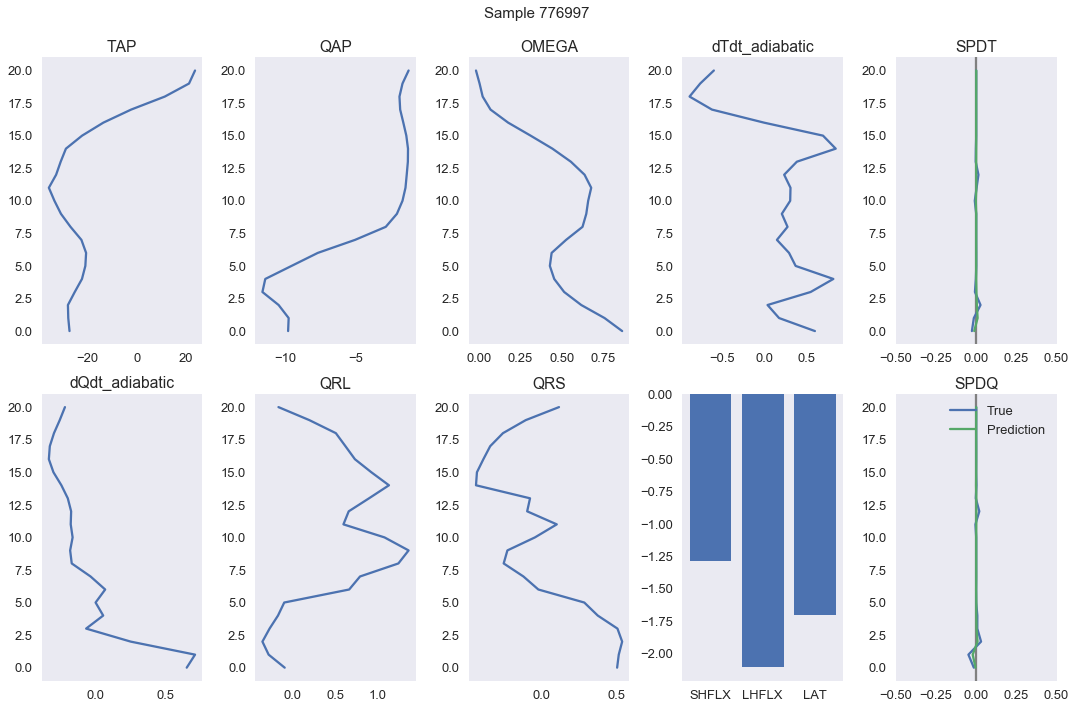

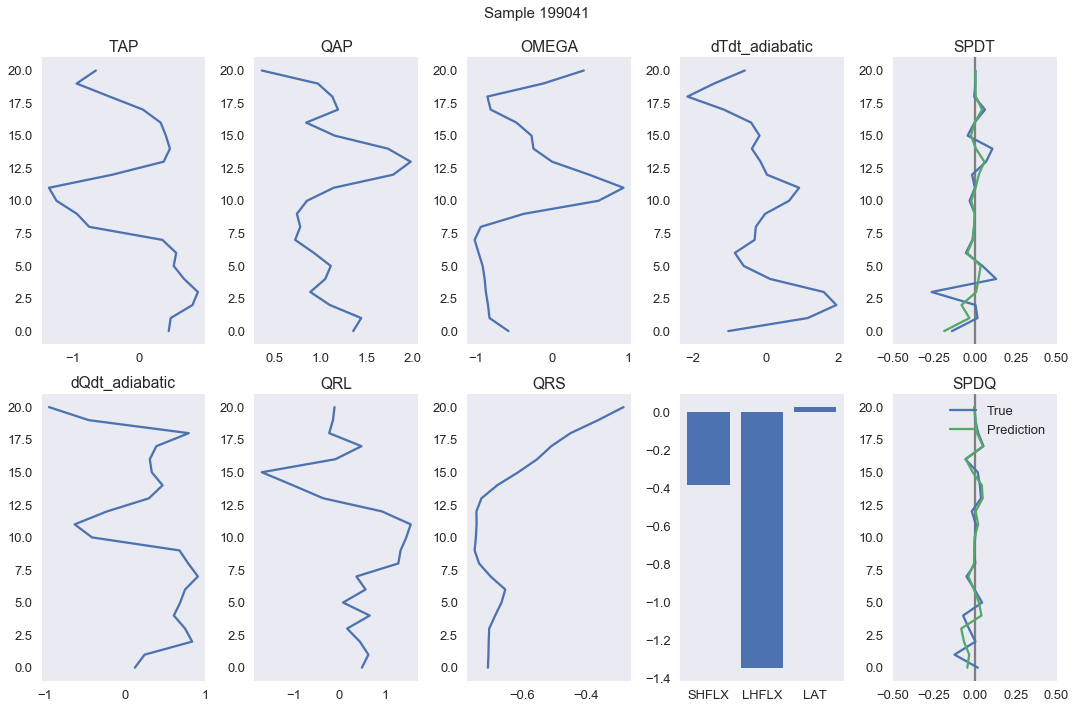

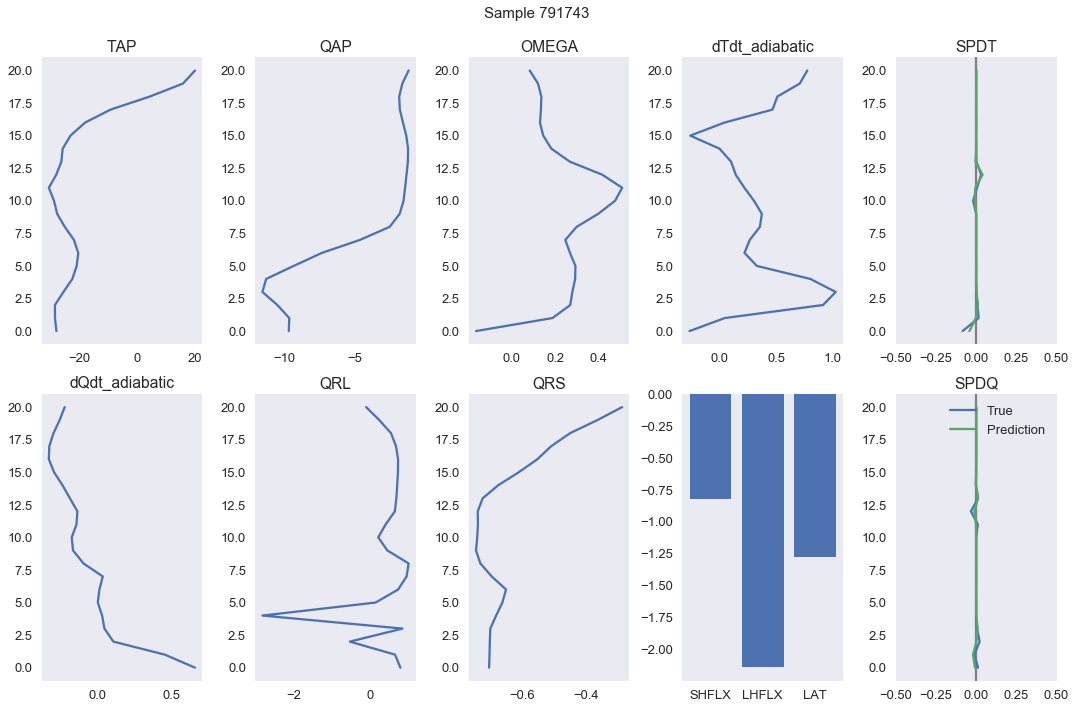

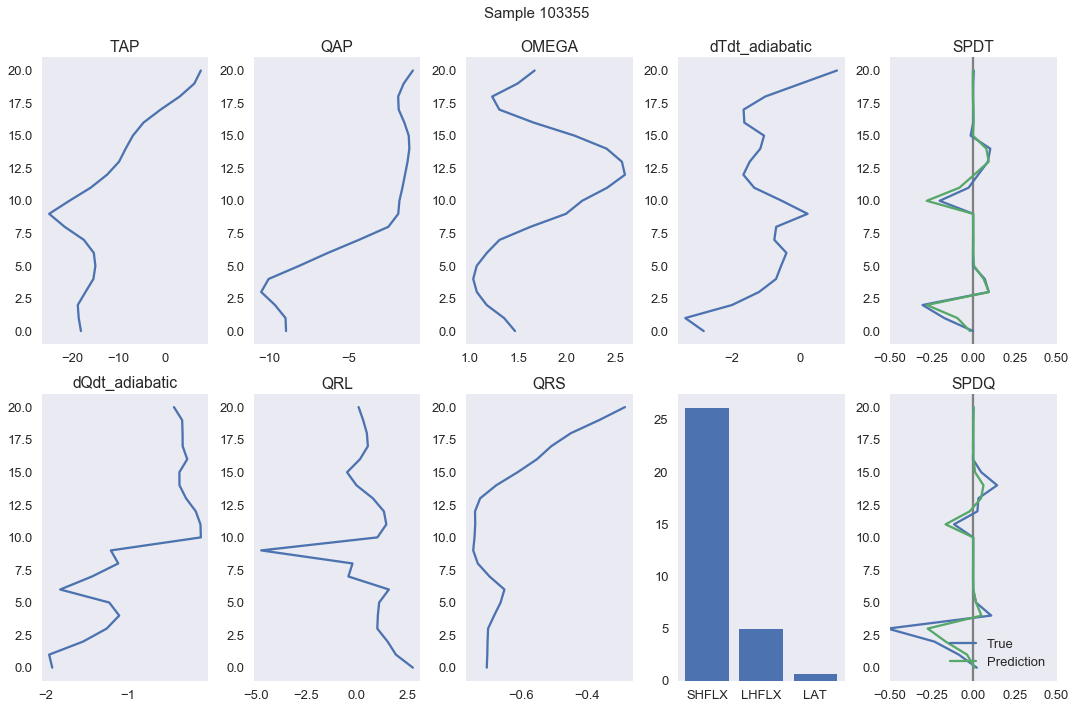

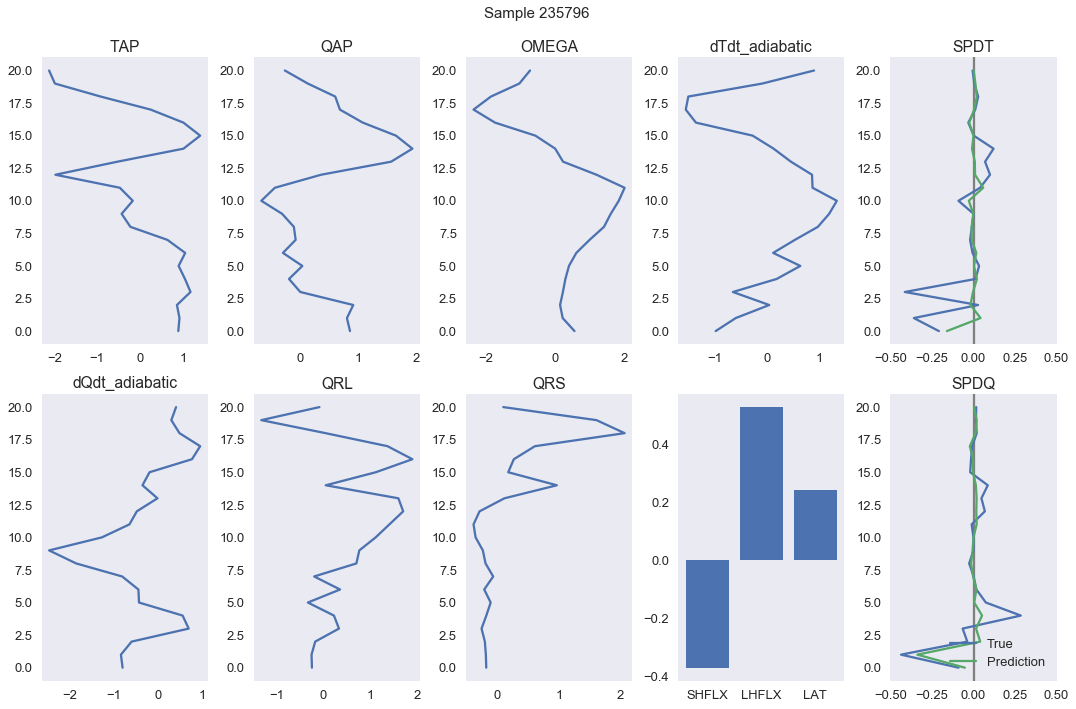

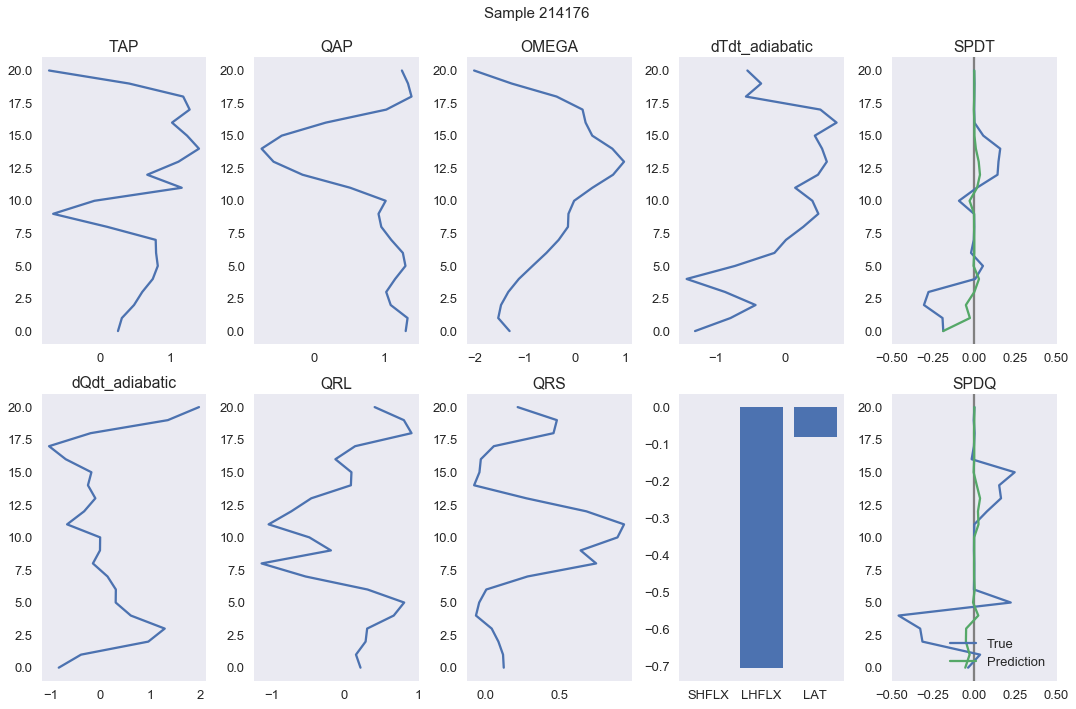

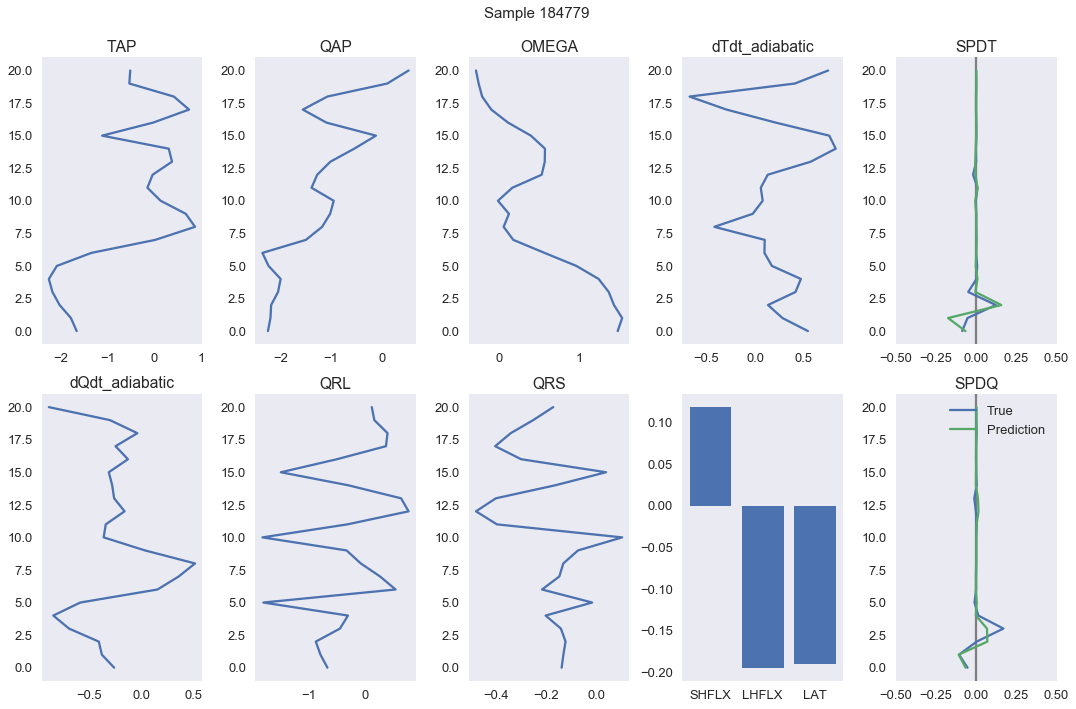

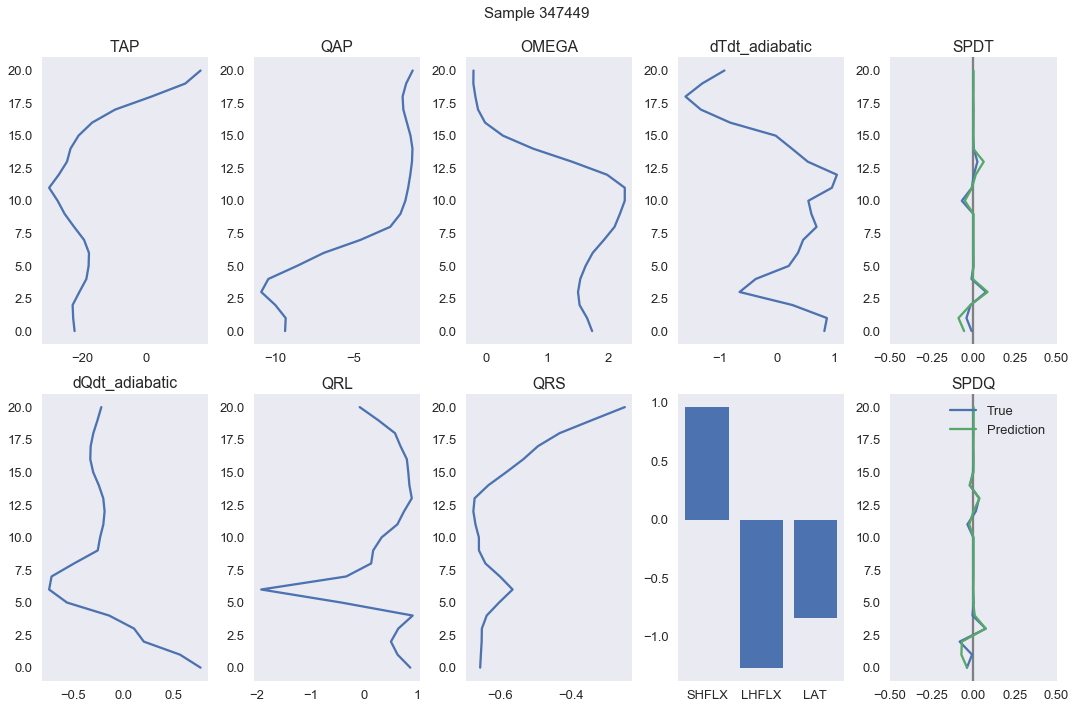

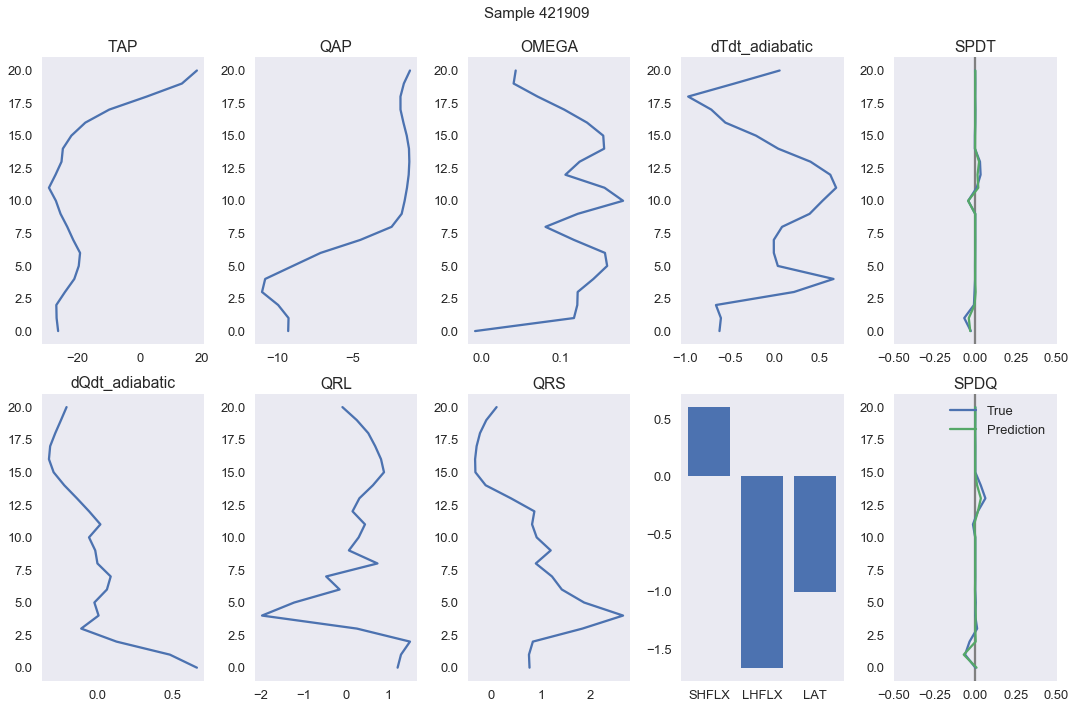

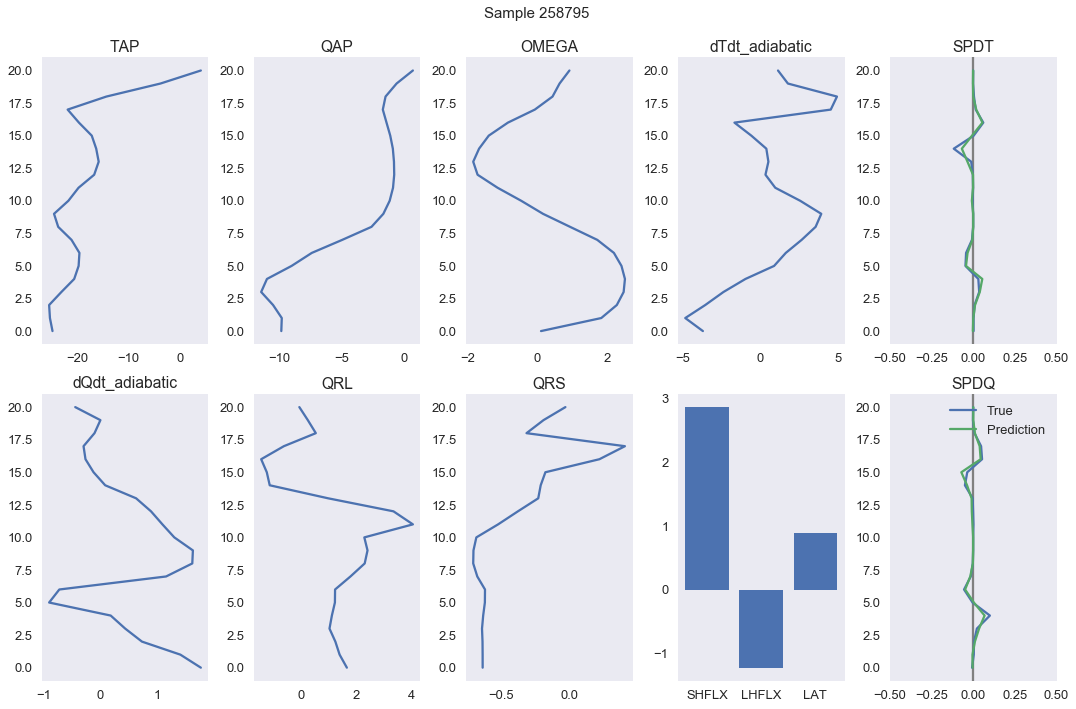

In [39]:
for i in list(np.random.randint(0, valid_set.features[0].shape[0], 10)):
    plot_stuff(valid_set.features[0], valid_set.features[1], valid_set.targets, preds,
               i, list(valid_set.feature_names), valid_set.target_names)

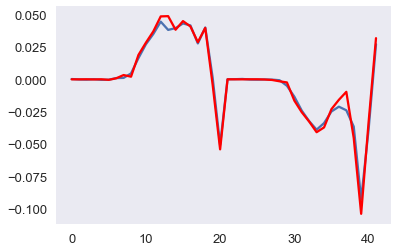

In [37]:
plt.plot(preds[i])
plt.plot(valid_set.targets[i], c='r')
plt.show()

In [55]:
# split into spdt and spdq
preds = np.reshape(preds, (preds.shape[0], 21, 2))
true = np.reshape(valid_set.targets, (valid_set.targets.shape[0], 21, 2))

In [112]:
# E along z axis
error = preds[:, :, :] - true[:preds.shape[0], :, :] 
error = np.reshape(error, (error.shape[0], -1))
error_dt = preds[:, :, 0] - true[:preds.shape[0], :, 0] 
error_dq = preds[:, :, 1] - true[:preds.shape[0], :, 1] 

In [58]:
mae = np.mean(np.abs(preds[:, :, :] - true[:preds.shape[0], :, :]))
mae

0.016872659388635268

In [59]:
np.mean(np.abs(preds[:, :, 0] - true[:preds.shape[0], :, 0]))

0.016644356283999021

In [60]:
np.mean(np.abs(preds[:, :, 1] - true[:preds.shape[0], :, 1]))

0.017100962493271643

In [96]:
np.mean(np.abs(true[:preds.shape[0], :, :]))

0.025882592534425354

In [70]:
lats = valid_batches.features[1][:preds.shape[0], -1]

In [77]:
# RMSE
def rmse_stat(x):
    return np.sqrt(np.mean(x**2))

In [84]:
def plot_lat_z_statistic(a, lats, statistic, cmap='inferno', vmin=None, vmax=None):
    b = binned_statistic(lats, a.T, statistic=statistic, bins=20, 
                         range=(lats.min(), lats.max()))
    mean_lats = (b[1][1:] + b[1][:-1]) / 2.
    mean_lats = ['%.0f' % l for l in mean_lats]
    plt.imshow(b[0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(range(len(mean_lats)), mean_lats)
    plt.colorbar()
    plt.show()

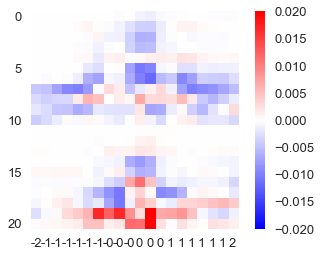

In [86]:
plot_lat_z_statistic(error_dt, lats, 'mean', 'bwr', -0.02, 0.02)

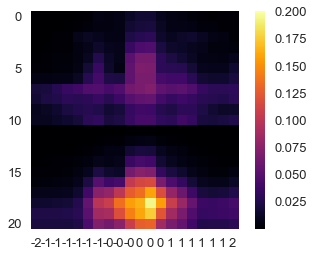

In [91]:
plot_lat_z_statistic(error_dt, lats, rmse_stat, vmax=0.2)

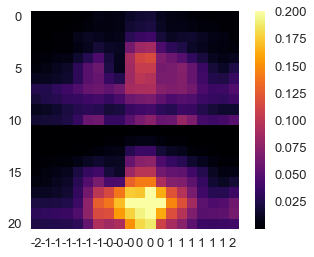

In [94]:
plot_lat_z_statistic(true[:preds.shape[0], :, 0], lats, np.std, vmax=0.2)

In [95]:
train_preds = model.predict_generator(train_batches.generate(shuffle=False), 
                                      train_batches.n_batches)

In [98]:
train_preds = np.reshape(train_preds, (train_preds.shape[0], 21, 2))
train_true = np.reshape(train_batches.targets, (train_batches.targets.shape[0], 21, 2))
train_preds.shape, train_true.shape

((3696128, 21, 2), (3696230, 21, 2))

In [99]:
# E along z axis
train_error_dt = train_preds[:, :, 0] - train_true[:train_preds.shape[0], :, 0] 
train_error_dq = train_preds[:, :, 1] - train_true[:train_preds.shape[0], :, 1] 

In [100]:
np.mean(np.abs(train_preds[:, :, :] - train_true[:train_preds.shape[0], :, :]))

0.016851513251780553

In [101]:
np.mean(np.abs(train_true[:train_preds.shape[0], :, :]))

0.025881500968938109

In [102]:
var = np.var(true)
var

0.004203581800124913

In [105]:
se = np.mean((preds[:, :, :] - true[:preds.shape[0], :, :]) ** 2)
se

0.0018571880335468524

In [106]:
1 - (se / var)

0.55818915347581322

In [107]:
se / var

0.44181084652418673

In [108]:
0.016/0.025

0.64

In [113]:
binned_se = binned_statistic(lats, error.T ** 2, statistic=np.mean, bins=20,
                              range=(lats.min(), lats.max()))

In [118]:
np.reshape(true, (true.shape[0], -1)).T[:, :preds.shape[0]]

(42, 924058)

In [119]:
error.T.shape

(42, 924032)

In [120]:
binned_var = binned_statistic(lats, np.reshape(true, (true.shape[0], -1)).T[:, :preds.shape[0]],
                              statistic=np.var, bins=20,
                              range=(lats.min(), lats.max()))

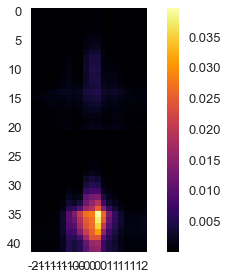

In [122]:
plt.imshow(binned_se[0], cmap='inferno')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

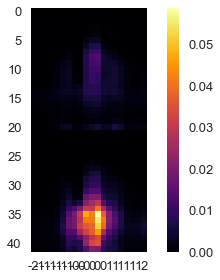

In [123]:
plt.imshow(binned_var[0], cmap='inferno')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

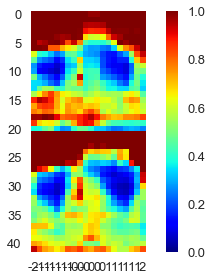

In [129]:
plt.imshow(binned_se[0] / binned_var[0], cmap='jet', vmin=0, vmax=1)
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

1271.2118255735274